# Assignment 3

### imports

In [1]:
# import packages
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
import attr
import random
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### load the data

In [2]:
# define the paths for the files
TRAIN_PATH = 'Train.csv'
POP_TEST_PATH = 'PopularityTest.csv'
RAND_TEST_PATH = 'RandomTest.csv'

# read the csv files
train = pd.read_csv(TRAIN_PATH)
test_pop = pd.read_csv(POP_TEST_PATH)
test_rand = pd.read_csv(RAND_TEST_PATH)

### explore the data

In [3]:
# get the unique items for each file
train_unique_items = train['ItemID'].unique()
test_pop_unique_items = set(list(test_pop['Item1'].unique()) + list(test_pop['Item2'].unique()))
test_rand_unique_items = set(list(test_rand['Item1'].unique()) + list(test_rand['Item2'].unique()))

# get the unique users for each file
train_unique_users = train['UserID'].unique()
test_pop_unique_users = test_pop['UserID'].unique()
test_rand_unique_users = test_rand['UserID'].unique()

In [4]:
# print some information on the data
print ('Items:')
print ('in the train data there are', len(train_unique_items), 'items')
print ('in the train data the min Id for items is',train_unique_items.min())
print ('in the train data the max Id for items is',train_unique_items.max())
print ('in the popularity test data there are', len(test_pop_unique_items), 'items')
print ('in the random test data there are', len(test_rand_unique_items), 'items\n')

print ('Users:')
print ('in the train data there are', len(train_unique_users), 'users')
print ('in the train data the min Id for users is',train_unique_users.min())
print ('in the train data the max Id for users is',train_unique_users.max())
print ('in the popularity test data there are', len(test_pop_unique_users), 'users')
print ('in the random test data there are', len(test_rand_unique_users), 'users\n')

# check items that exist in the test but not in the train
items_only_pop = set(test_pop_unique_items).difference(set(train_unique_items))
items_only_rand = set(test_rand_unique_items).difference(set(train_unique_items))

# check users that exist in the test but not in the train
users_only_pop = set(test_pop_unique_users).difference(set(train_unique_users))
users_only_rand = set(test_rand_unique_users).difference(set(train_unique_users))

print ('popolarity test:')
print ('items', items_only_pop, 'exists in the test but not in the train')
print ('users', users_only_pop, 'exists in the test but not in the train-> there is no such users')
print ('random test:')
print ('items', items_only_rand, 'exists in the test but not in the train')
print ('users', users_only_rand, 'exists in the test but not in the train-> there is no such users')

Items:
in the train data there are 3705 items
in the train data the min Id for items is 1
in the train data the max Id for items is 3706
in the popularity test data there are 2356 items
in the random test data there are 3321 items

Users:
in the train data there are 6040 users
in the train data the min Id for users is 1
in the train data the max Id for users is 6040
in the popularity test data there are 6040 users
in the random test data there are 6040 users

popolarity test:
items {1750} exists in the test but not in the train
users set() exists in the test but not in the train-> there is no such users
random test:
items {1750} exists in the test but not in the train
users set() exists in the test but not in the train-> there is no such users


### Preprocessing for the data

<b> 1. convert all the ids (users+items) start from 0 and not from 1

In [5]:
train_copy = train.copy()
train_copy['ItemID'] -= 1
train_copy['UserID'] -= 1
# add rank 1 for all the rows- thw user consumed this item
train_copy['rank'] = 1

<b> 2. create matrix with users&items in the rows&columns and rank in the matrix

In [6]:
# the function get the train data and convert it to matrix of users and items in rows and columns and ranks in the matrix.
# the dunction return the matrix
def matrix_user_item(train):
    # make a copt of the train data and add rank column with 1
    train_copy = train.copy()
    train_copy['rank'] = 1
    # create matrix with columns&rows of users&items and the values in the matrix are the ranks(1 if user consumed item and 0 else)
    matrix_users_items = csr_matrix((train_copy['rank'], (train_copy['UserID'], train_copy['ItemID']))).toarray()
    
    return matrix_users_items.astype(np.float32)

In [7]:
# call the function from above to create the matrix
train_user_item_matrix = matrix_user_item(train_copy)

<b> 3. create dictionary for the negative items probabilities per user

In [8]:
# the function get the train data and calculate the probability by populraity and uniform for each user depending on items not consumed 
# the function return dict with the user as key and 2 array probabilities for each condition and the number of items in value
# in addition return the probabilities of items
def create_dict_negative_items_per_user(train):
    # initilaize array with probabilities for each items with zeros (probability to choose this items)
    probabilities = np.zeros(train['ItemID'].max()+1)
    # for each item get the probability for choosing it
    probabilities_items = pd.DataFrame(train['ItemID'].value_counts(normalize=True).sort_index())
    # insert probabilities in their places in probabilities array
    for i in list(probabilities_items.index):
        probabilities[i] = probabilities_items.loc[i,].values[0]
    
    # initilaize dictionary for user and his negative items
    negative_items_per_user = {}
    # for each user
    for user in range(train['UserID'].max()+1):
        # initialize the probabilites for this user
        user_prob =  probabilities.copy()
        # get the items that the user consumed
        user_items = train[train['UserID']==user]['ItemID'].unique()
        # all the items that the user consumed set the probability to 0
        for item in range(len(user_items)):
            # get the index of item
            item_index = user_items[item]
            # set the value in this index to 0
            user_prob[item_index] = 0
            
        # normalize the popularity probabilities
        user_pop_probabilities = user_prob/sum(user_prob)
        # transform the popularity probabilities to uniform (random) probabilities
        user_rand_probabilities = np.nan_to_num(user_pop_probabilities/user_pop_probabilities)
        user_rand_probabilities = user_rand_probabilities/sum(user_rand_probabilities)
        # add user to dictionary: key=user, value=[probabilities by popularity, probabilities by random, number of items for this user]
        negative_items_per_user[user] = [user_pop_probabilities, user_rand_probabilities, len(user_items)] 
    
    return negative_items_per_user, probabilities

In [9]:
# call the function from above to create the dictionary
negative_items_per_user, probabilities = create_dict_negative_items_per_user(train_copy)

### functions for running the models

<b> 1. define parameters

In [10]:
@attr.s
class model_param():
    # parameters for spliting to train+vaildation   
    num_items = train['ItemID'].unique().max()
    val_quant = 0.2
    test_type = 'random' # random or popularity
    ###negatives = None     # dictionary

    # parameters for the NN architecture
    in_features = None
    num_net_channels = [2500, 500, 50]
    early_stopping = True
    early_stopping_num_epochs = 7
    early_stopping_min_improvement = 0
    
    # parameters for NN training
    tr_batch_size = 256
    ###val_test_batch_size = None
    
    num_epochs = 50
    lr = 1e-3
    lr_step_decay = 1
    weight_decay = 1e-4
    
    criterion_func = nn.BCELoss
    weight_to_one = 0
    optimizer_func = optim.Adam
    metric = 'recon_mae'
    val_metric = 'accuracy'

<b> 2. split to train+validation

In [11]:
# the function get the matrix of users&items, spliting the data into train&validation and return train, validation, users
# for validation, dictionary for train and validation of the new ids for users
def split_train_validation_per_user(train_matrix, val_ratio=0.2):
    # sample users for the validation set (spliting train+validation) according to the val_ratio
    validation_users = random.sample(range(len(train_matrix)), round(val_ratio*len(train_matrix)))
    # sort the list we got
    validation_users = sorted(validation_users)
    # get the users that rest for the train (all the users that are not in the validation)
    train_users = [i for i in range(len(train_matrix)) if i not in validation_users]
    
    # split the train matrix to train+validation by the users we got above for each set
    train = train_matrix[train_users]
    validation =  train_matrix[validation_users]

    return train, validation, validation_users

<b> 3. arrange validation set into validation_train and validation test to convert to a regular structure for training </b>
for each user we remove 1 item example so all the rest will be in the validation_train and the 1 rest example will be the positive example (the item that the user consumed) in the validation_test). then we sample 1 negative sample for the validation_test according to the condition (popularity or random) and then we get validation with 1 row for each user with 2 items: 1 consumed and the other didn't.

In [12]:
def get_correct_validation_set(validation_matrix, validation_users_indexes, dict_negative_items_per_user, prob):
    # get a copy of vaildation matrix
    train_valid_matrix = validation_matrix.copy()
    # create a dict for the positive examples
    users_positive_dict = {}
    
    for new_index, values in enumerate(train_valid_matrix):
        # get 1 positive example for each user by random choice where the value is 1
        positive_item = np.random.choice(np.where(train_valid_matrix[new_index] == 1)[0], size=1)[0]
        # update the dictionary: key= index for user & value = the positive item
        users_positive_dict[new_index] = positive_item
        # update the matrix to be with 0 for this user & item because it will be in the validation 
        train_valid_matrix[new_index][positive_item]= 0 
    
    # create a dict for the negative examples
    users_negative_dict = {}
    # list fot the updates of probabilities
    val_users_items_dict = []
    for new_index, old_index in enumerate(validation_users_indexes):
        # if the condition is random (uniform)
        if args.test_type.lower() == 'random':
            # get 1 negative example for each user by random choice with the probabilities we caclulate before for this user
            negative_item = np.random.choice(np.arange(args.num_items), 1, p=dict_negative_items_per_user[old_index][1])
            # crate new propability for validation user's items because we made changes 
            user_items = train_valid_matrix[new_index]
            user_prop = (1-user_items)
            user_prob_pop = user_prop/sum(user_prop)
            val_users_items_dict.append(np.array(user_prob_pop).tolist())
            
        # if the condition is popularity
        else:
            # get 1 negative example for each user by random choice with the probabilities we caclulate before for this user
            negative_item = np.random.choice(np.arange(args.num_items), 1, p=dict_negative_items_per_user[old_index][0])
            # crate new propability for validation user's items because we made changes 
            user_items = train_valid_matrix[new_index]
            user_prop = prob.copy()
            user_prop = (1-user_items)*user_prop
            user_prob_pop = user_prop/sum(user_prop)
            val_users_items_dict.append(np.array(user_prob_pop).tolist())
            
        # update the dictionary: key= index for user & value = the negative item
        users_negative_dict[new_index]=negative_item[0]

    # create df for the validation test
    df = pd.DataFrame(range(len(users_positive_dict)), columns=['val_UserID'])
    df['Item1'] = pd.DataFrame.from_dict(users_positive_dict, orient='index')
    df['Item2']  = pd.DataFrame.from_dict(users_negative_dict, orient='index')
    df['item_prop']= val_users_items_dict
    
    return train_valid_matrix, df

<b> 4. Data Loader

In [13]:
# the function of dataloader for the validation set
class ValidationDataset(Dataset):
    def __init__(self,user_item_matrix, data):       
        # define the matrix of user-item, users_id, items (1 & 2) and item probabilities and convert to torch
        X = user_item_matrix.copy()
        self.user_item = torch.Tensor(X)
        self.user_id = torch.Tensor(range(len(X))).to(torch.int)
        self.item1 = torch.Tensor(data['Item1'].values).to(torch.int)
        self.item2 = torch.Tensor(data['Item2'].values).to(torch.int)
        self.item_prob = torch.Tensor(data['item_prop']).to(torch.float64)
    
    def __getitem__(self, ind):
        # get a specific row with all the information
        user = self.user_id[ind]
        user_vec = self.user_item[ind,:]
        item1 = self.item1[ind]
        item2 = self.item2[ind]
        item_prob = self.item_prob[ind,:]
        return user_vec, user, item1, item2, item_prob
    
    def __len__(self):
        # calculate the length
        return self.user_item.shape[0]

In [14]:
# the function of dataloader for the train set
class TrainDataset(Dataset):
    def __init__(self,user_item_matrix):       
        # define the matrix of user-item and convert to torch
        X = user_item_matrix.copy()
        self.user_item = torch.Tensor(X)
    
    def __getitem__(self, ind):
        # get a specific row
        user_vec = self.user_item[ind,:]
        return user_vec
    
    def __len__(self):
        # calculate the length
        return self.user_item.shape[0]

<b> 5. create the autoenconder

In [15]:
# create the class for the auto enconder network
class AutoEncoder(nn.Module):
    def __init__(self, in_features, num_features):
        super(AutoEncoder, self).__init__()
        # create the encoder
        # start with linear layer
        encoder_layers = [nn.Linear(in_features, num_features[0])]
        # for each hidden layer append relu (activation func) and another linear layer
        for i in range(1, len(num_features)):
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Linear(num_features[i-1], num_features[i]))
        # finally add another relu
        encoder_layers += [nn.ReLU()]
        
        # create the decoder
        decoder_layers = []
        # for each hidden layer append linear layer and then relu function
        for j in range(len(num_features)-1):
            decoder_layers.append(nn.Linear(num_features[-j-1], num_features[-j-2]))
            decoder_layers.append(nn.ReLU())
        # at the end append another linear layer and finally sigmoid function
        decoder_layers += [nn.Linear(num_features[0],in_features)]
        decoder_layers.append(nn.Sigmoid())
        
        # define the enconder and decoder with all the lists with layers and functions
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)
        
        # print the network we got
        print(self.modules)
    
    # the forward level
    def forward(self, x):
        # apply the encoder and decoder on the input and return the output
        encoding = self.encoder(x)
        reconstruction = self.decoder(encoding)
        return reconstruction

<b> 6. Training

In [16]:
# the function compute the mean absolute error with the input and the output and return it
def get_recon_mae(x_input,x_recon):
    x = x_input.flatten().detach().numpy()
    recon = x_recon.flatten().detach().numpy()
    return mean_absolute_error(x, recon)

# the function compute the accuracy with the classification and return it
def get_val_label_accuracy(bitcalssification):
    # the true label is always 0 in validation 
    return np.array(bitcalssification == 0).sum()/len(bitcalssification) 

In [17]:
# the function get the output, 2 items, probabilities and make predictions for the tests files and return array with
# the prediction (in true/false format)
def predict_for_test_format(recon, item1, item2, item_prob, normalize=True):
    # get array for probabilities
    prob_1 = torch.gather(recon,1,item1.resize(item1.shape[0],1).long()) 
    prob_2 = torch.gather(recon,1,item2.resize(item2.shape[0],1).long())
    # if we want to normalize
    if normalize:
        # we would like to weighted each probability by prob*(1-neg.prob)
        prob_1_norm = torch.gather(item_prob,1,item1.resize(item1.shape[0],1).long())
        prob_1 = prob_1.double()/prob_1_norm.double()
        prob_2_norm = torch.gather(item_prob,1,item2.resize(item2.shape[0],1).long())
        prob_2 = prob_2.double()/prob_2_norm.double()
    
    # ‘0’ if you predict that the first item was the item that was liked by the user and ‘1’ if you predict that the second item was liked by the user.
    # if prob_1>=prob_2 the bitClassification is 0 if prob_2>prob_1 the bitClassification is 1
    return np.array(prob_2 > prob_1)

In [18]:
# the function get the network, dataloader, loss, parameters and normzlization and make evaluation with the validation
# the function calculate the loss, mean absolute error, predict the results and calculate the accuracy. Finally if return all metrics
def infer(net, dataloader, criterion, normalization):
    # convert to eval mode for evalusation
    net.eval()
    # initialize loss to 0 and list for the accuracy
    running_loss = 0
    running_metric = []  
    # for the data we have
    for user_vec, user, i1, i2, item_prob in dataloader:
        with torch.no_grad():
            # get the output of the network
            recon = net(user_vec)
            # calculate loss and mea
            loss = criterion(recon, user_vec).item()
            recon_metric = get_recon_mae(user_vec,recon)
            # make predictions and calculate accuracy
            bitClassification = predict_for_test_format(recon, i1, i2, item_prob, normalize=normalization)
            metric = get_val_label_accuracy(bitClassification)
        # update loss and acuuracy's list
        running_loss += loss
        running_metric.append(metric)
    
    return running_loss/ len(dataloader), np.array(recon_metric).mean(), np.array(running_metric).mean()

In [19]:
# the function get the parameters, network, dataloader for train and validation and normalization.
# the function apply the training with the evaluation on the data, in addition caculate some metrics
# the function return all metrics for train and validation, the epoch it stops and the output of the network  
def training_loop(
    args,
    net,
    tr_dataloader,
    val_dataloader=None,
    normalization=True):
    
    # the loss function and leraning rate
    criterion = args.criterion_func()
    lr = args.lr
    
    # initialize all the varaibles for metrics
    tr_loss, val_loss = [None] * args.num_epochs, [None] * args.num_epochs, 
    tr_recon_metric, val_recon_metric, val_metric = [None] * args.num_epochs, [None] * args.num_epochs, [None] * args.num_epochs

    # for each epoch
    for epoch in range(args.num_epochs):
        # the optimizer we used - inside the loop to support lr decay
        optimizer = args.optimizer_func(net.parameters(), lr=lr, weight_decay=args.weight_decay)
        # define train mode for training
        net.train()
        # initilaize the loss and mae for training
        running_tr_loss = 0
        running_tr_metric = []

        # for the data
        for x in tr_dataloader:
            # initialize gradient
            optimizer.zero_grad()
            
            # apply the network
            recon = net(x)
            # if we want to use weights for the loss (for the epochs)
            if args.weight_to_one >0:
                # calculate the weights
                w = (x.clone()-(1-args.weight_to_one)).abs()
                # calculate the loss
                loss = nn.BCELoss(w, size_average=False)(recon, x)
            # if not just calculate the loss
            else:
                loss = criterion(recon, x)
            # apply the backward with the loss we got
            loss.backward()
            # apply step for the updates
            optimizer.step()
            # calculate mae and update the measures
            batch_metric = get_recon_mae(x,recon)
            running_tr_loss += loss
            running_tr_metric.append(batch_metric)
        
        # update the learning rate
        lr = lr*args.lr_step_decay 
        
        # update loss and mae in the train lists
        tr_loss[epoch] = running_tr_loss.item() / len(tr_dataloader)
        tr_recon_metric[epoch]  = np.array(running_tr_metric).mean()    
        # if we use validation 
        if val_dataloader:
            # calculate and update the metrics for validation
            val_loss[epoch], val_recon_metric[epoch], val_metric[epoch] = infer(net, val_dataloader, criterion, normalization)   
            print(f"epoch {epoch} validation recon mae: {val_recon_metric[epoch]} validation test accuracy: {val_metric[epoch]}.")

            # check if we want early stopping if needded # early stopping by val metric 
            if args.early_stopping:
                # check if the minimum epochs applied
                if epoch >= args.early_stopping_num_epochs:
                    # calculate the improvment in the measures 
                    improvement = (val_metric[epoch] - val_metric[epoch - args.early_stopping_num_epochs])
                    # if the improvment is large than the treshold we define so continue and else break the training
                    if improvement < args.early_stopping_min_improvement:
                        break                  
    
    print(f"Done training for {epoch} epochs.")

    return tr_loss, val_loss, tr_recon_metric, val_recon_metric, val_metric,  epoch, recon  


<b>7. plots

In [20]:
# the function plot 2 plots in the same plot by the type of metric and the number of epochs we gave 
def plot_metric_per_epoch(metric_res_train, metric_res_test, metric_type, num_epochs):
    # get the x axis for the plot bu number of epochs
    range_epochs = range(num_epochs)
    # create figure for plot
    fig, ax = plt.subplots()
    # if we have 2 plots
    if metric_res_train!= None:
        # plot the train metric
        ax.plot(range_epochs, metric_res_train, color='royalblue', alpha=0.6, label='train')
    # plot the validation metric
    ax.plot(range_epochs, metric_res_test, color='deeppink', alpha=0.6, label='validation')
    
    # add titles and legend and show the plot
    ax.set_title(f'{metric_type} per Epoch')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(f'{metric_type}')
    lgnd = ax.legend()
    plt.show()

--------------
## run the 2 models: random and popularity

### Random

<b> 1. define the number of epochs with validation data

In [21]:
# call the function with the parameters
args = model_param()
# if need valdidation
if args.val_quant !=0:
    # split the train into train and validation
    train_new_matrix, val_matrix , val_users_indexes = split_train_validation_per_user(train_user_item_matrix, args.val_quant)
    # rearrange the validation set into val_train, val_test so it will be in the correct reconstruct
    val_train_matrix, val_test_df = get_correct_validation_set(val_matrix , val_users_indexes, negative_items_per_user, probabilities)
    # define dataloader for validation
    val_dataloader = DataLoader(ValidationDataset(val_train_matrix,val_test_df),batch_size=val_train_matrix.shape[0])
# if not need validation define the train matrix with all data
else:
    train_new_matrix = train_user_item_matrix.copy()
# define dataloader for training 
tr_dataloader = DataLoader(TrainDataset(train_new_matrix),batch_size=args.tr_batch_size)
# define number of features to input
args.in_features = train_user_item_matrix.shape[1]

In [22]:
# change parameter
args.weight_to_one = 0.6
# create the network of autoencoder
net = AutoEncoder(in_features=args.in_features,num_features=args.num_net_channels)
# apply the training on the network
tr_loss, val_loss, tr_recon_metric, val_recon_metric, val_metric, epoch, recon = training_loop(args,net,tr_dataloader,val_dataloader,normalization=False)

<bound method Module.modules of AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3706, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=50, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=2500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2500, out_features=3706, bias=True)
    (5): Sigmoid()
  )
)>
epoch 0 validation recon mae: 0.08232692629098892 validation test accuracy: 0.8700331125827815.
epoch 1 validation recon mae: 0.07612986117601395 validation test accuracy: 0.8725165562913907.
epoch 2 validation recon mae: 0.0713556632399559 validation test accuracy: 0.8774834437086093.
epoch 3 validation recon mae: 0.07373467087745667 validation test accuracy: 0.8783112582781457.
epoch 4 validation recon mae: 0.0665

In [23]:
# get the number of epochs and print the accuracy
final_epoch = val_metric.index(max(val_metric[:epoch])) 
print(f"validation set best accuracy: {val_metric[final_epoch+1]} for epoch: {final_epoch}")

validation set best accuracy: 0.9221854304635762 for epoch: 23


<b> 2. plot the metrics

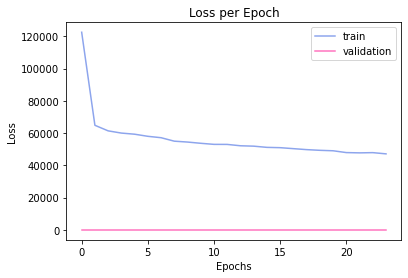

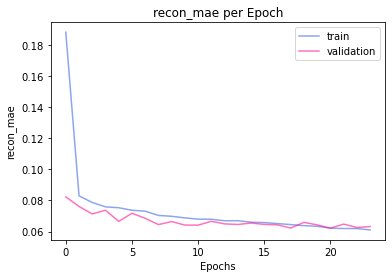

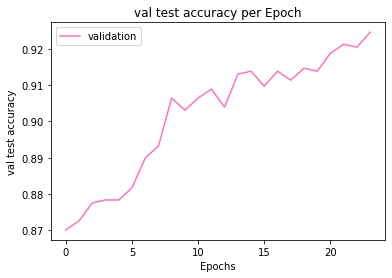

In [24]:
# plot all the measures
plot_metric_per_epoch(metric_res_train=tr_loss[:final_epoch+1],metric_res_test=val_loss[:final_epoch+1],metric_type='Loss',num_epochs=final_epoch+1)
plot_metric_per_epoch(metric_res_train=tr_recon_metric[:final_epoch+1],metric_res_test=val_recon_metric[:final_epoch+1],metric_type='recon_mae',num_epochs=final_epoch+1)
plot_metric_per_epoch(metric_res_train=None,metric_res_test=val_metric[:final_epoch+1],metric_type='val test accuracy',num_epochs=final_epoch+1)

<b> 3. train the whole data (train+validation together) with the chosen number of epochs

In [25]:
# define the number of fetaures for the input, the parameter of weights and the number of epoch we got
args.in_features = train_user_item_matrix.shape[1]
args.weight_to_one = 0.6
args.num_epochs = final_epoch+1

# define train data loader and initilaize the validation dataloader to None
tr_dataloader = DataLoader(TrainDataset(train_user_item_matrix),batch_size=args.tr_batch_size)
val_dataloader = None 

# create the network of autoencoder and apply the training on the network
uniform_net = AutoEncoder(in_features=args.in_features,num_features=args.num_net_channels)
tr_loss, val_loss, tr_recon_metric, val_recon_metric, val_metric, epoch, recon = training_loop(args,uniform_net,tr_dataloader,val_dataloader,normalization=False)

<bound method Module.modules of AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3706, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=50, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=2500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2500, out_features=3706, bias=True)
    (5): Sigmoid()
  )
)>
Done training for 23 epochs.


<b> 4. predict the test file for random

In [26]:
# preprocess the test data as we did for the train (indexes start from 0 instead 1)
random_df_temp = test_rand.copy()
random_df_temp['Item1'] -= 1
random_df_temp['Item2'] -= 1
random_df_temp['UserID'] -= 1

# create the probabilities feature for dataloader
val_users_items_dict = []
for userid in random_df_temp['UserID']:
    val_users_items_dict.append(np.array(negative_items_per_user[userid][1]).tolist())
random_df_temp['item_prop']= val_users_items_dict

# define the data loader to the test
test_dataloader = DataLoader(ValidationDataset(train_user_item_matrix,random_df_temp),batch_size=train_user_item_matrix.shape[0])

# define the mode to eval for evaluation
uniform_net.eval()
# for the data
for user_vec, user, i1, i2, item_prob in test_dataloader:
    with torch.no_grad():       
        # apply the network
        recon = uniform_net(user_vec)
        # make prediction
        bitClassification = predict_for_test_format(recon, i1, i2, item_prob)

# add new columns for the prediction and change it to int (0 or 1) from bolean (false or true)
test_rand['bitClassification'] = bitClassification
test_rand['bitClassification'] = test_rand['bitClassification'].astype(int)
# write the results to csv
test_rand.to_csv("RandomTest_with_bitClassification.csv", index=False)

### Popularity

<b> 1. define the number of epochs with validation data

In [27]:
# call the function with the parameters and change the type to popularity
args = model_param()
args.test_type = 'popularity' 
# if need valdidation
if args.val_quant !=0:
    # split the train into train and validation
    train_new_matrix, val_matrix , val_users_indexes = split_train_validation_per_user(train_user_item_matrix, args.val_quant)
    # rearrange the validation set into val_train, val_test so it will be in the correct reconstruct
    val_train_matrix, val_test_df = get_correct_validation_set(val_matrix , val_users_indexes,negative_items_per_user, probabilities)
    # define dataloader for validation
    val_dataloader = DataLoader(ValidationDataset(val_train_matrix,val_test_df),batch_size=val_train_matrix.shape[0])
# if not need validation define the train matrix with all data
else:
    train_new_matrix = train_user_item_matrix.copy()
# define dataloader for training 
tr_dataloader = DataLoader(TrainDataset(train_new_matrix),batch_size=args.tr_batch_size)
# define number of features to input
args.in_features = train_user_item_matrix.shape[1]

<b> 2. check what give us the best results- with/without normalize

without normalization

In [28]:
# change parameter
args.weight_to_one = 0.6
# create the network of autoencoder
net2 = AutoEncoder(in_features=args.in_features,num_features=args.num_net_channels)
# apply the training on the network
tr_loss, val_loss, tr_recon_metric, val_recon_metric, val_metric, epoch, recon = training_loop(args,net2,tr_dataloader,val_dataloader,normalization=False)

<bound method Module.modules of AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3706, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=50, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=2500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2500, out_features=3706, bias=True)
    (5): Sigmoid()
  )
)>
epoch 0 validation recon mae: 0.0848550796508789 validation test accuracy: 0.5728476821192053.
epoch 1 validation recon mae: 0.08193396776914597 validation test accuracy: 0.5852649006622517.
epoch 2 validation recon mae: 0.07808230817317963 validation test accuracy: 0.5968543046357616.
epoch 3 validation recon mae: 0.07631535828113556 validation test accuracy: 0.6175496688741722.
epoch 4 validation recon mae: 0.0702

In [29]:
# get the number of epochs and print the accuracy
final_epoch = val_metric.index(max(val_metric[:epoch])) 
print(f"validation set best accuracy: {val_metric[final_epoch+1]} for epoch: {final_epoch}")

validation set best accuracy: 0.7756622516556292 for epoch: 32


with normalization

In [30]:
# change parameter
args.weight_to_one = 0.6
# create the network of autoencoder
net2 = AutoEncoder(in_features=args.in_features,num_features=args.num_net_channels)
# apply the training on the network
tr_loss, val_loss, tr_recon_metric, val_recon_metric, val_metric, epoch, recon = training_loop(args,net2,tr_dataloader,val_dataloader,normalization=True)

<bound method Module.modules of AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3706, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=50, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=2500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2500, out_features=3706, bias=True)
    (5): Sigmoid()
  )
)>
epoch 0 validation recon mae: 0.08328607678413391 validation test accuracy: 0.5554635761589404.
epoch 1 validation recon mae: 0.08496033400297165 validation test accuracy: 0.5902317880794702.
epoch 2 validation recon mae: 0.07107097655534744 validation test accuracy: 0.5943708609271523.
epoch 3 validation recon mae: 0.08135952800512314 validation test accuracy: 0.6258278145695364.
epoch 4 validation recon mae: 0.075

In [31]:
# get the number of epochs and print the accuracy
final_epoch = val_metric.index(max(val_metric[:epoch])) 
print(f"validation set best accuracy: {val_metric[final_epoch+1]} for epoch: {final_epoch}")

validation set best accuracy: 0.8145695364238411 for epoch: 31


The results are: <br>
- without:  best accuracy: 0.776 for epoch: 32
- with:     best accuracy: 0.815 for epoch: 31

From the results above we can see that normalize the predicted probability for class 1, with the negative probability of its item per user achieved better results. <br>
The metrics below has been done to the model with normalization.

<b> 3. plot the metrics

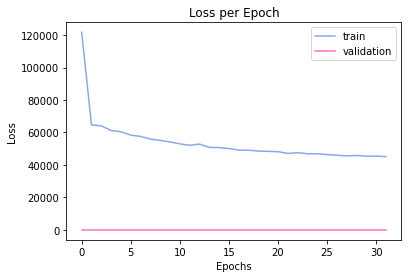

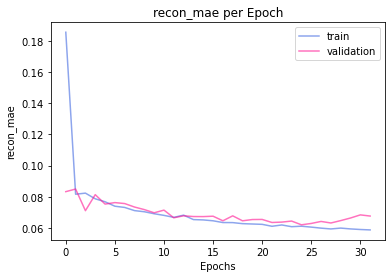

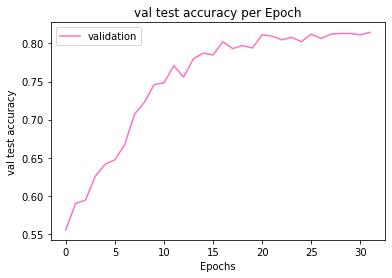

In [32]:
# plot all the measures
plot_metric_per_epoch(metric_res_train=tr_loss[:final_epoch+1],metric_res_test=val_loss[:final_epoch+1],metric_type='Loss',num_epochs=final_epoch+1)
plot_metric_per_epoch(metric_res_train=tr_recon_metric[:final_epoch+1],metric_res_test=val_recon_metric[:final_epoch+1],metric_type='recon_mae',num_epochs=final_epoch+1)
plot_metric_per_epoch(metric_res_train=None,metric_res_test=val_metric[:final_epoch+1],metric_type='val test accuracy',num_epochs=final_epoch+1)

<b> 4. train the whole data (train+validation together) with the chosen number of epochs

In [33]:
# define the number of fetaures for the input, the parameter of weights, type and the number of epoch we got
args.test_type = 'popularity' 
args.in_features = train_user_item_matrix.shape[1]
args.weight_to_one = 0.6
args.num_epochs = final_epoch+1

# define train data loader and initilaize the validation dataloader to None
tr_dataloader = DataLoader(TrainDataset(train_user_item_matrix),batch_size=args.tr_batch_size)
val_dataloader = None 

# create the network of autoencoder and apply the training on the network
pop_net = AutoEncoder(in_features=args.in_features,num_features=args.num_net_channels)
tr_loss, val_loss, tr_recon_metric, val_recon_metric, val_metric, epoch, recon = training_loop(args,pop_net,tr_dataloader,val_dataloader,normalization=True)

<bound method Module.modules of AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3706, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=50, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=2500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2500, out_features=3706, bias=True)
    (5): Sigmoid()
  )
)>
Done training for 31 epochs.


<b> 5. predict the test file for popularity

In [34]:
# preprocess the test data as we did for the train (indexes start from 0 instead 1)
pop_df_temp = test_pop.copy()
pop_df_temp['Item1'] -=1
pop_df_temp['Item2'] -=1
pop_df_temp['UserID'] -=1

# create the probabilities feature for dataloader
val_users_items_dict = []
for userid in pop_df_temp['UserID']:
    val_users_items_dict.append(np.array(negative_items_per_user[userid][0]).tolist())
pop_df_temp['item_prop']= val_users_items_dict

# define the data loader to the test
test_dataloader = DataLoader(ValidationDataset(train_user_item_matrix,pop_df_temp),batch_size=train_user_item_matrix.shape[0])

# define the mode to eval for evaluation
pop_net.eval()
# for the data
for user_vec, user, i1, i2, item_prob in test_dataloader:
    with torch.no_grad():
        # apply the network
        recon = pop_net(user_vec)
        # make prediction
        bitClassification = predict_for_test_format(recon, i1, i2, item_prob)

# add new columns for the prediction and change it to int (0 or 1) from bolean (false or true)        
test_pop['bitClassification'] = bitClassification
test_pop['bitClassification'] = test_pop['bitClassification'].astype(int)
# write the results to csv
test_pop.to_csv("PopularityTest_with_bitClassification.csv", index=False)